In [1]:
import tifffile
import numpy as np
import pandas as pd
import math
import random
import torch
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import scipy.stats as stats
import cv2
import imageio
import os

# from __future__ import division
from scipy.ndimage import gaussian_filter
from scipy.ndimage import convolve as filter2
from matplotlib.patches import FancyArrowPatch
from scipy.spatial import cKDTree
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

import warnings
warnings.filterwarnings('ignore')

Here read the raw data, which has 4600 frames each.

In [2]:
dir_data = '../iAdo2m_jRGECO1a_raw_data/'
file_iAdo2m = os.path.join(dir_data, 'iAdo2m_27202-31801.tif')
file_jRGECO1a = os.path.join(dir_data, 'jRGECO1a_27202-31801.tif')

if os.path.exists(file_iAdo2m) and os.path.exists(file_jRGECO1a):
    iAdo2m = tifffile.imread(file_iAdo2m)
    jRGEC01a = tifffile.imread(file_jRGECO1a)
    print('Files loaded successfully')
else: 
    print('File loading failed')

print(f'Dimension of iAdo2m: {iAdo2m.shape}')
print(f'Dimension of jRGEC01: {jRGEC01a.shape}')

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


Files loaded successfully
Dimension of iAdo2m: (4600, 359, 359)
Dimension of jRGEC01: (4600, 359, 359)


In [3]:
iAdo2m_phase = tifffile.imread('../iAdo2m_phase.tiff')
jRGEC01a_phase = tifffile.imread('../jRGEC01a_phase.tiff')
print(iAdo2m_phase.shape, jRGEC01a_phase.shape)

iAdo2m_ws_vx = np.load('../temp_output/ix.npy')
iAdo2m_ws_vy = np.load('../temp_output/iy.npy')
jRGEC01a_ws_vx = np.load('../temp_output/jx.npy')
jRGEC01a_ws_vy = np.load('../temp_output/jy.npy')

(4600, 359, 359) (4600, 359, 359)


In [4]:
def conv(ws, method, sigma=None):

    _, h, w = ws.shape
    convo = np.zeros_like(ws)

    if method == 'average':
        kernel = np.ones((3,3)) / 3*3

        for i in range(ws.shape[0]):
            convo[i] = np.convolve(ws[i].flatten(), kernel.flatten(), mode='same').reshape(h,w)
    
    elif method == 'gaussian':
        sigma = 1 if sigma is None else sigma
        
        for i in range(ws.shape[0]):
            convo[i] = gaussian_filter(ws[i], sigma=sigma, mode='constant')
    
    else:
        return ws
    
    return convo

iAdo2m_ws_x = conv(iAdo2m_ws_vx, method=None)
iAdo2m_ws_y = conv(iAdo2m_ws_vy, method=None)
jRGEC01a_ws_x = conv(jRGEC01a_ws_vx, method=None)
jRGEC01a_ws_y = conv(jRGEC01a_ws_vy, method=None)

In [5]:
iAdo2m_phase_mod = tifffile.imread('../iAdo2m_phase_mod.tiff')
jRGEC01a_phase_mod = tifffile.imread('../jRGEC01a_phase_mod.tiff')
print(iAdo2m_phase_mod.max(), iAdo2m_phase_mod.min(), jRGEC01a_phase_mod.max(), jRGEC01a_phase_mod.min())

3.1415923 -3.1415927 3.1415923 -3.1415927


In [6]:
def find_original(mod_phase, sign, st=1050, et=1450, hmin=0, hmax=359, wmin=0, wmax=359, recurrent_times=15, 
                  top=10, continue_t_len_down=100, continue_t_len_up=1000):

    phase = mod_phase[:, hmin:hmax, wmin:wmax].copy()
    point_set = []
    continue_time = []
    origin_point_set = []
    Max_t = []

    points = list(np.asarray(np.nonzero(~np.isnan(iAdo2m[0, hmin:hmax, wmin:wmax]))).transpose(1,0))

    if sign == 'iAdo2m':
        for p in points:
            if phase[:st, p[0], p[1]].max()<0 and phase[et, p[0], p[1]]>0 and phase[:st, p[0], p[1]].max()<=np.pi:
                max = phase[et:, p[0], p[1]].max()
                min = phase[:st, p[0], p[1]].min()
                max_t = np.where(phase[:, p[0], p[1]] == max)[0]
                min_t = np.where(phase[:, p[0], p[1]] == min)[0][-1]
                # print(max_t, min_t)
                if min_t >= 200 and max_t[-1] >= 2800:
                    point_set.append(np.asarray([p[0], p[1]]))
                    continue_time.append(max_t[-1] - max_t[0])
                    Max_t.append(max_t[0])
        
        above_threshold_indices = [idx for idx, value in enumerate(continue_time) if value > continue_t_len_down]

        new_points = []
        new_max = []
        for index in above_threshold_indices:
            new_points.append(point_set[index])
            new_max.append(Max_t[index])
        top_k_max_t = sorted(new_max)[:top]
        for idx in range(len(new_max)):
            if new_max[idx] in top_k_max_t:
                origin_point_set.append(new_points[idx])
    
    elif sign == 'jRGEC01a':
        for p in points:
            if phase[:st, p[0], p[1]].max()<0 and phase[et, p[0], p[1]]>0 and phase[:st, p[0], p[1]].max()<=np.pi:
                max = phase[et:, p[0], p[1]].max()
                min = phase[:st, p[0], p[1]].min()
                max_t = np.where(phase[:, p[0], p[1]] == max)[0]
                min_t = np.where(phase[:, p[0], p[1]] >= 3)[0][0]
                # print(max_t, min_t)
                if min_t >= st and max_t[0] >= et and max_t[-1] <= 3000:
                    point_set.append(np.asarray([p[0], p[1]]))
                    continue_time.append(max_t[-1] - min_t)
                    Max_t.append(max_t[-1])
        
        above_threshold_indices = [idx for idx, value in enumerate(continue_time) if ((value < continue_t_len_up) and (value > continue_t_len_down))]

        new_points = []
        new_max = []
        for index in above_threshold_indices:
            new_points.append(point_set[index])
            new_max.append(Max_t[index])
        top_k_max_t = sorted(new_max)[::-1][:top]
        top_k_min_t = sorted(new_max)[:top]
        for idx in range(len(new_max)):
            if new_max[idx] in top_k_max_t+top_k_min_t:
                origin_point_set.append(new_points[idx])
    
    else:
        raise ValueError('Please tell me which item should be analysed...')
    
    final_origin = []
    for ele in origin_point_set:
        final_origin.append(np.array([ele[0]+hmin, ele[1]+wmin]))
        
    return final_origin

iAdo2m_phase_origin = find_original(iAdo2m_phase_mod, hmin=50, hmax=320, wmin=180, wmax=330, 
                                    sign='iAdo2m', continue_t_len_down=300, continue_t_len_up=None)
jRGEC01a_phase_origin = find_original(jRGEC01a_phase_mod, hmin=50, hmax=320, wmin=180, wmax=330, 
                                      sign='jRGEC01a', continue_t_len_down=800, continue_t_len_up=1100)

In [7]:
def select_origin_region(origins, radius=10.0, method='hierarchy', wave_num=1):
    if method == 'ckdtree':
        kd_tree = cKDTree(np.asarray(origins))
        pairs_within_radius = kd_tree.query_pairs(radius)
        print(pairs_within_radius)

        non_isolated_points = set()
        for i, j in pairs_within_radius:
            non_isolated_points.add(tuple(origins[i]))
            non_isolated_points.add(tuple(origins[j]))
        non_isolated_points = np.array(list(non_isolated_points))

        return non_isolated_points
    
    elif method == 'hierarchy':
        Z = linkage(origins, method='complete')
        clusters = fcluster(Z, radius, criterion='distance')

        cluster_dict = {}
        for i in range(len(origins)):
            cluster_label = clusters[i]
            if cluster_label not in cluster_dict:
                cluster_dict[cluster_label] = []
            cluster_dict[cluster_label].append(origins[i])
        # for key, value in cluster_dict.items():
        #     print(f"Cluster {key}: {value}")

        sorted_dict = dict(sorted(cluster_dict.items(), key=lambda x: len(x[1]), reverse=True))

        if wave_num == 1:
            return np.asarray(list(sorted_dict.values())[0])
        else:
            return np.asarray(tuple(np.asarray(list(sorted_dict.values())[i]) for i in range(wave_num)))

    else:
        raise ValueError('Please enter a valid cluster method...')

iAdo2m original point: [[101 271]
 [101 272]
 [105 272]
 [105 273]
 [105 276]]
jRGEC01a original points: [array([[ 78, 241],
        [ 80, 238],
        [ 81, 239],
        [ 81, 240],
        [ 81, 241],
        [ 82, 240],
        [ 82, 241],
        [ 83, 241]]) array([[137, 291],
                            [137, 292],
                            [139, 297],
                            [140, 297]])]


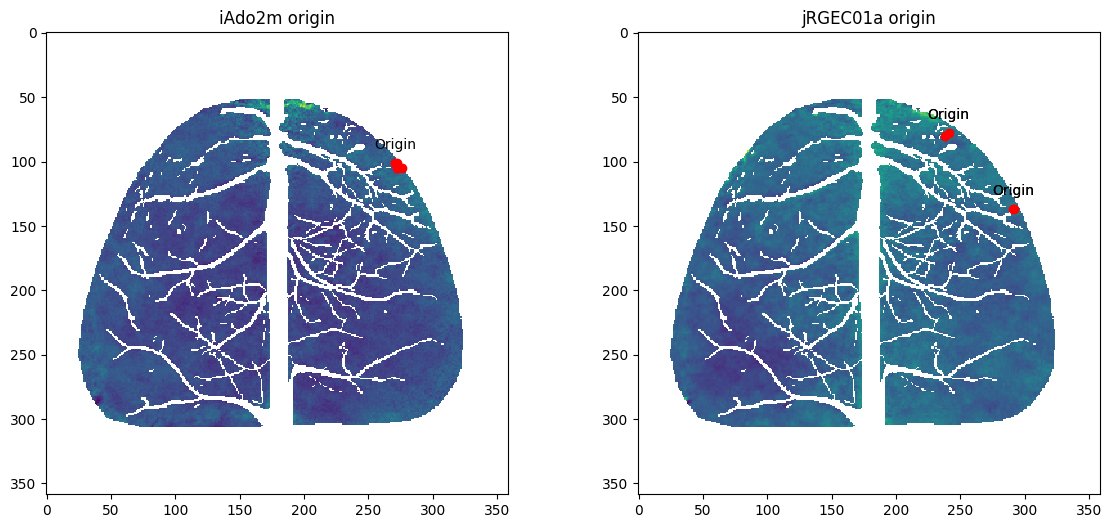

In [8]:
iAdo2m_phase_origin_region = select_origin_region(iAdo2m_phase_origin, radius=10, method='hierarchy', wave_num=1)
jRGEC01a_phase_origin_region = select_origin_region(jRGEC01a_phase_origin, radius=10, method='hierarchy', wave_num=2)
print("iAdo2m original point:", iAdo2m_phase_origin_region)
print("jRGEC01a original points:", jRGEC01a_phase_origin_region)

top_k = len(iAdo2m_phase_origin_region)
wave_num = 1
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.imshow(iAdo2m[0])
for k in range(top_k):
    plt.scatter(x=iAdo2m_phase_origin_region[k][1], y=iAdo2m_phase_origin_region[k][0], c='red')
plt.annotate(f'Origin', (iAdo2m_phase_origin_region[0,1], iAdo2m_phase_origin_region[0,0]), textcoords='offset points', xytext=(0,10), ha='center')
plt.title('iAdo2m origin')
top_k = len(jRGEC01a_phase_origin_region)
wave_num = 2
plt.subplot(122)
plt.imshow(jRGEC01a[0])
for i in range(wave_num):
    for k in range(top_k):
        plt.scatter(x=jRGEC01a_phase_origin_region[i][k][1], y=jRGEC01a_phase_origin_region[i][k][0], c='red')
        plt.annotate('Origin', (jRGEC01a_phase_origin_region[i][0,1], jRGEC01a_phase_origin_region[i][0,0]), textcoords='offset points', xytext=(0,10), ha='center')
plt.title('jRGEC01a origin')
plt.savefig('../Origin region.png')
plt.show()

In [9]:
def min_circle(points):
    def is_inside(circle, point):
        distance = math.hypot(circle[0] - point[0], circle[1] - point[1])
        return distance <= circle[2]

    def update_circle(circle, point):
        center_x = (circle[0] + point[0]) / 2
        center_y = (circle[1] + point[1]) / 2
        radius = math.hypot(center_x - point[0], center_y - point[1])
        return (center_x, center_y, radius)

    random_point = random.choice(points)
    min_circle = (random_point[0], random_point[1], 0)

    for p in points:
        if not is_inside(min_circle, p):
            min_circle = update_circle(min_circle, p)
            
    return min_circle

In [10]:
def vis_wave(image, phase, idx, wave_x, wave_y, origin_region, wave_num, 
             title_name=None, mag=None, thre=3, step=10, phase_step=10, 
             linewidth=1.0, head_width=1.5, head_length=2, save=False, quiver_thre=0.01):
    t, h, w = image.shape
    if mag is None:
        mag = np.sqrt(wave_x.copy()**2 + wave_y.copy()**2)
    if thre is None:
        thre = np.percentile(mag[idx], 25)

    fig, ax = plt.subplots(figsize=(8, 6))
    image_temp = image[1050+idx].copy()
    image_temp[np.isnan(image_temp)] = 0
    im = ax.imshow(image_temp, cmap='jet')
    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.1, shrink=0.6)
    cbar.set_label('delta F/F0', rotation=0, labelpad=10)
    for i in range(0, h, step): 
        for j in range(0, w, step): 
            if mag[idx, i, j]>thre and image[1050+idx, i, j]>0.4: 
                ax.arrow(j, i, wave_x[idx,i,j], wave_y[idx,i,j], fc='white', ec='white', linewidth=linewidth, head_width=head_width, head_length=head_length, length_includes_head=False)
    
    if wave_num == 1:
        Points = origin_region.copy()
        Points[:, [0, 1]] = Points[:, [1, 0]]
        center_x, center_y, radius = min_circle(Points)
        center_x = int(center_x)
        center_y = int(center_y)

        ax.scatter(Points[:, 0], Points[:, 1], color='red', label='Origins')
        circle = plt.Circle((center_x, center_y), 5, color='white', fill=False, linewidth=2, label='Original Region')
        plt.annotate('Origin', (center_x, center_y), textcoords='offset points', xytext=(15,10), fontsize=16, ha='center', color='white')
        ax.add_patch(circle)

        endpoints = np.argwhere(abs(phase[idx+phase_step]-phase[idx, center_y, center_x])<quiver_thre)
        # print(center_x, center_y,endpoints)
        for e in range(0, len(endpoints), ):
            u = (endpoints[e,0] - center_x) / 4
            v = (endpoints[e,1] - center_y) / 4
            ax.arrow(center_x, center_y, u, v, fc='green', ec='green', linewidth=linewidth, head_width=head_width, head_length=head_length, length_includes_head=False)
    
    elif wave_num > 1:
        Center_x = np.zeros(wave_num)
        Center_y = np.zeros(wave_num)
        for i in range(wave_num):
            Points = origin_region[i].copy()
            Points[:, [0, 1]] = Points[:, [1, 0]]
            center_x, center_y, radius = min_circle(Points)
            Center_x[i] = int(center_x)
            Center_y[i] = int(center_y)

            ax.scatter(Points[:, 0], Points[:, 1], color='red', label='Origins')
        
        center_x = int(np.mean(Center_x))
        center_y = int(np.mean(Center_y))
        circle = plt.Circle((center_x, center_y), 5, color='white', fill=False, linewidth=2, label='Original Region')
        plt.annotate('Origin', (center_x, center_y), textcoords='offset points', xytext=(15,10), fontsize=16, ha='center', color='white')
        ax.add_patch(circle)

        endpoints = np.argwhere(abs(phase[idx+phase_step]-phase[idx, center_y, center_x])<quiver_thre)
        # print(center_x, center_y,endpoints)
        for e in range(0, len(endpoints), ):
            u = (endpoints[e,0] - center_x) / 4
            v = (endpoints[e,1] - center_y) / 4
            ax.arrow(center_x, center_y, u, v, fc='green', ec='green', linewidth=linewidth, head_width=head_width, head_length=head_length, length_includes_head=False)

    if save:
        plt.title(f'{title_name} flow at origin t{1050+idx}')
        plt.savefig(f'../{title_name}_origin_flow_{1050+idx}.pdf')

    plt.show()

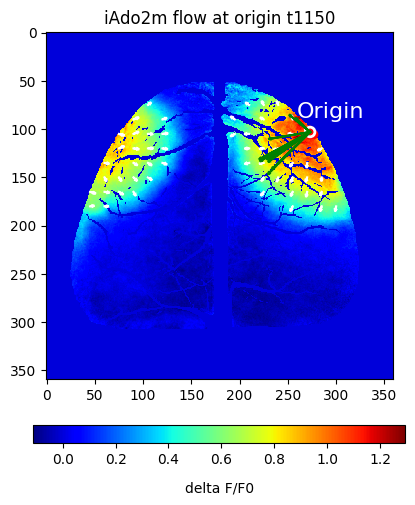

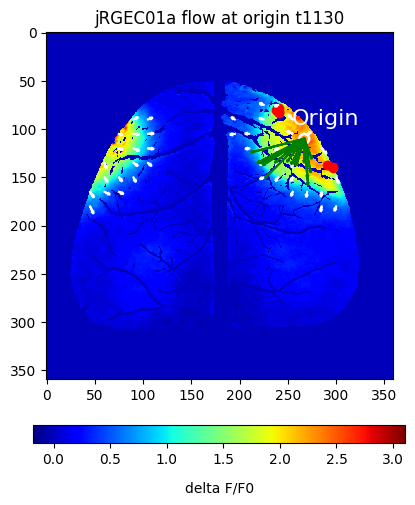

In [11]:
vis_wave(iAdo2m, iAdo2m_phase, idx=100, step=15, wave_x=iAdo2m_ws_x, wave_y=iAdo2m_ws_y, origin_region=iAdo2m_phase_origin_region, wave_num=1,  
         phase_step=1, title_name='iAdo2m', thre=2, linewidth=1.5, save=True, quiver_thre=1e-5)
vis_wave(jRGEC01a, jRGEC01a_phase, idx=80, step=15, wave_x=jRGEC01a_ws_x, wave_y=jRGEC01a_ws_y, origin_region=jRGEC01a_phase_origin_region, wave_num=2, 
         phase_step=1, title_name='jRGEC01a', thre=2, linewidth=1.5, save=True, quiver_thre=1e-5)

In [12]:
def vis_wave_local(image, phase, idx, wave_x, wave_y, origin_region, wave_num, sign=None, 
                   title_name=None, mag=None, thre=3, step=10, phase_step=10, 
                   linewidth=1.0, head_width=1.5, head_length=2, save=False, quiver_thre=0.01):
    t, h, w = image.shape
    if mag is None:
        mag = np.sqrt(wave_x.copy()**2 + wave_y.copy()**2)
    if thre is None:
        thre = np.percentile(mag[idx], 25)

    fig, ax = plt.subplots(figsize=(8, 6))
    image_temp = image[1050+idx].copy()
    image_temp[np.isnan(image_temp)] = 0
    im = ax.imshow(image_temp[60:180,200:320], extent=(200,320,180,60), cmap='jet')
    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.1, shrink=0.6)
    cbar.set_label('delta F/F0', rotation=0, labelpad=10)
    for i in range(0, h, step): 
        for j in range(0, w, step): 
            if mag[idx, i, j]>thre: 
                ax.arrow(j, i, wave_x[idx,i,j], wave_y[idx,i,j], fc='white', ec='white', linewidth=linewidth, head_width=head_width, head_length=head_length, length_includes_head=False)
    
    if wave_num == 1:
        Points = origin_region.copy()
        Points[:, [0, 1]] = Points[:, [1, 0]]
        center_x, center_y, radius = min_circle(Points)
        center_x = int(center_x)
        center_y = int(center_y)

        # ax.scatter(Points[:, 0], Points[:, 1], color='green', label='Origins')
        circle = plt.Circle((center_x, center_y), 3, color='white', fill=False, linewidth=2, label='Original Region')
        plt.annotate('Origin', (center_x, center_y), textcoords='offset points', xytext=(15,10), fontsize=16, ha='center', color='white')
        ax.add_patch(circle)

        endpoints = np.argwhere(abs(phase[idx+phase_step]-phase[idx, center_y, center_x])<quiver_thre)
        # print(center_x, center_y,endpoints)
        for i in range(0, len(endpoints)):
            u = (endpoints[i,0] - center_x) / 4
            v = (endpoints[i,1] - center_y) / 4
            ax.arrow(center_x, center_y, u, v, fc='green', ec='green', linewidth=linewidth, head_width=head_width, head_length=head_length, length_includes_head=False)
    
    elif wave_num > 1:
        Center_x = np.zeros(wave_num)
        Center_y = np.zeros(wave_num)
        for i in range(wave_num):
            Points = origin_region[i].copy()
            Points[:, [0, 1]] = Points[:, [1, 0]]
            center_x, center_y, radius = min_circle(Points)
            Center_x[i] = int(center_x)
            Center_y[i] = int(center_y)

            # ax.scatter(Points[:, 0], Points[:, 1], color='green', label='Origins')

        center_x = int(np.mean(Center_x))
        center_y = int(np.mean(Center_y))
        circle = plt.Circle((center_x, center_y), 3, color='white', fill=False, linewidth=2, label='Original Region')
        plt.annotate('Origin', (center_x, center_y), textcoords='offset points', xytext=(15, 10), fontsize=16, ha='center', color='white')
        ax.add_patch(circle)

        endpoints = np.argwhere(abs(phase[idx+phase_step]-phase[idx, center_y, center_x])<quiver_thre)
        # print(center_x, center_y, endpoints)
        for i in range(0, len(endpoints)):
            u = (endpoints[i,0] - center_x) / 4
            v = (endpoints[i,1] - center_y) / 4
            ax.arrow(center_x, center_y, u, v, fc='green', ec='green', linewidth=linewidth, head_width=head_width, head_length=head_length, length_includes_head=False)

    if save:
        plt.title(f'{title_name} flow at origin t{1050+idx} (local)')
        plt.savefig(f'../{title_name}_origin_flow_local_{1050+idx}.pdf')

    plt.show()

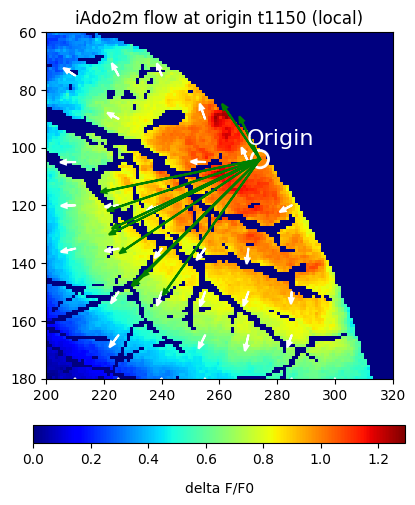

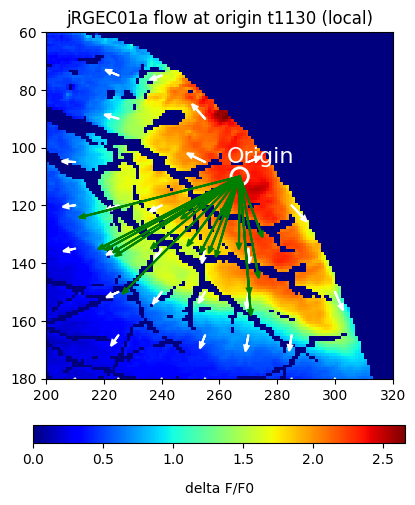

In [13]:
vis_wave_local(iAdo2m, iAdo2m_phase, idx=100, step=15, wave_x=iAdo2m_ws_x, wave_y=iAdo2m_ws_y, origin_region=iAdo2m_phase_origin_region, wave_num=1,  
         phase_step=10, title_name='iAdo2m', thre=2, linewidth=1.5, save=True, quiver_thre=1e-5)
vis_wave_local(jRGEC01a, jRGEC01a_phase, idx=80, step=15, wave_x=jRGEC01a_ws_x, wave_y=jRGEC01a_ws_y, origin_region=jRGEC01a_phase_origin_region, wave_num=2, sign=True, 
         phase_step=10, title_name='jRGEC01a', thre=2, linewidth=1.5, save=True, quiver_thre=1e-5)

In [14]:
def polar_hist(wave_x, wave_y, idx=None, color=None, thres=0.5, title_name=None, save=False):

    wave_x_flat = wave_x.flatten()
    wave_y_flat = wave_y.flatten()

    r = np.sqrt(wave_x_flat**2 + wave_y_flat**2)
    theta = np.arctan2(wave_y_flat, wave_x_flat)

    filtered_r = r[r > thres]
    filtered_theta = theta[r > thres]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='polar')
    n, bins, _ = ax.hist(filtered_theta, bins=30, color=color, edgecolor='black', density=True)

    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
    
    if save:
        plt.title(f'{title_name} wave direction at t{1050+idx}')
        plt.savefig(f'../{title_name}_wave_direction_at_t{1050+idx}.pdf')

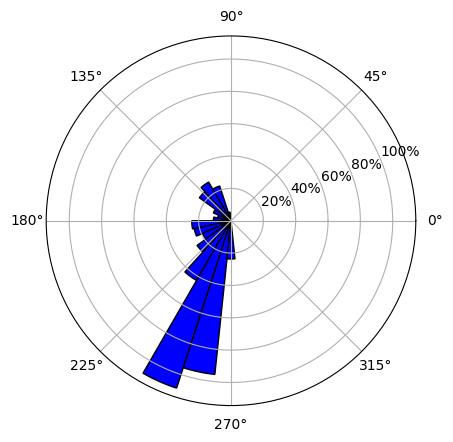

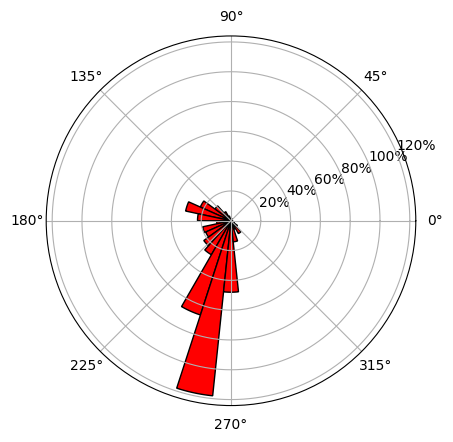

In [15]:
polar_hist(iAdo2m_ws_x[100,70:180,220:300], -iAdo2m_ws_y[100,70:180,220:300], idx=100, color='blue', thres=2, title_name='iAdo2m', save=False)
polar_hist(jRGEC01a_ws_x[80,70:180,220:300], -jRGEC01a_ws_y[80,70:180,220:300], idx=80, color='red', thres=2, title_name='jRGEC01a', save=False)

In [57]:
def pre_hist(wave_x, wave_y, thres=2):

    total_filtered_theta = []
    current_frame_data_percentage = []
    for i in range(len(wave_x)):
        wave_x_flat = wave_x[i].flatten()
        wave_y_flat = wave_y[i].flatten()
        r = np.sqrt(wave_x_flat**2 + wave_y_flat**2)
        theta = np.arctan2(wave_y_flat, wave_x_flat)
        filtered_theta = theta[r > thres]
        total_filtered_theta.append(filtered_theta)
    
    total_len = 0
    count_list = []
    for j in range(len(total_filtered_theta)):
        count_list.append(len(total_filtered_theta[j]))
        total_len += len(total_filtered_theta[j])

    current_frame_data_percentage = [c / total_len for c in count_list]

    return total_filtered_theta, current_frame_data_percentage, total_len

total_filtered_theta1, current_frame_data_percentage1, total_len1 = pre_hist(iAdo2m_ws_x[:,70:180,220:300], -iAdo2m_ws_y[:,70:180,220:300], thres=2)
total_filtered_theta2, current_frame_data_percentage2, total_len2 = pre_hist(jRGEC01a_ws_x[:,70:180,220:300], -jRGEC01a_ws_y[:,70:180,220:300], thres=2)

In [101]:
def polar_hist_mp4(total_filtered_theta1, total_filtered_theta2, current_frame_data_percentage1, current_frame_data_percentage2, 
                   idx, frame_number, color1=None, color2=None, thres=2):

    fig = plt.figure(figsize=(14,5))
    ax1 = fig.add_subplot(121, projection='polar')
    ax1.set_ylim(0, 1)
    n1, bins1, _ = ax1.hist(total_filtered_theta1[idx], bins=20, color=color1, edgecolor='black', density=False, 
                          weights=np.full(len(total_filtered_theta1[idx]), current_frame_data_percentage1[idx]))
    # ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))

    ax2 = fig.add_subplot(122, projection='polar')
    ax2.set_ylim(0, 1)
    n2, bins2, _ = ax2.hist(total_filtered_theta2[idx], bins=20, color=color2, edgecolor='black', density=False, 
                          weights=np.full(len(total_filtered_theta2[idx]), current_frame_data_percentage2[idx]))
    # ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))

    # plt.text(-np.pi/2, 1.2, f"{frame_number} frame", ha='center', fontsize=10)
    plt.suptitle(f'polar hist MP4 - {frame_number} frame', fontsize=16)

    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    plt.close(fig)  # Close the figure to avoid memory leaks
    return image

# Generate frames for the MP4 animation
polar_hist = []
for i in range(300):
    polar_hist.append(polar_hist_mp4(total_filtered_theta1, total_filtered_theta2, current_frame_data_percentage1, current_frame_data_percentage2, 
                                     idx=i, frame_number=i+1050, color1='blue', color2='red'))

# Write frames to an MP4 file
with imageio.get_writer('../polar_hist.mp4', mode='I', fps=15) as writer:
    for frame in polar_hist:
        writer.append_data(frame)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1400, 500) to (1408, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x56aaf80] Warning: data is not aligned! This can lead to a speed loss


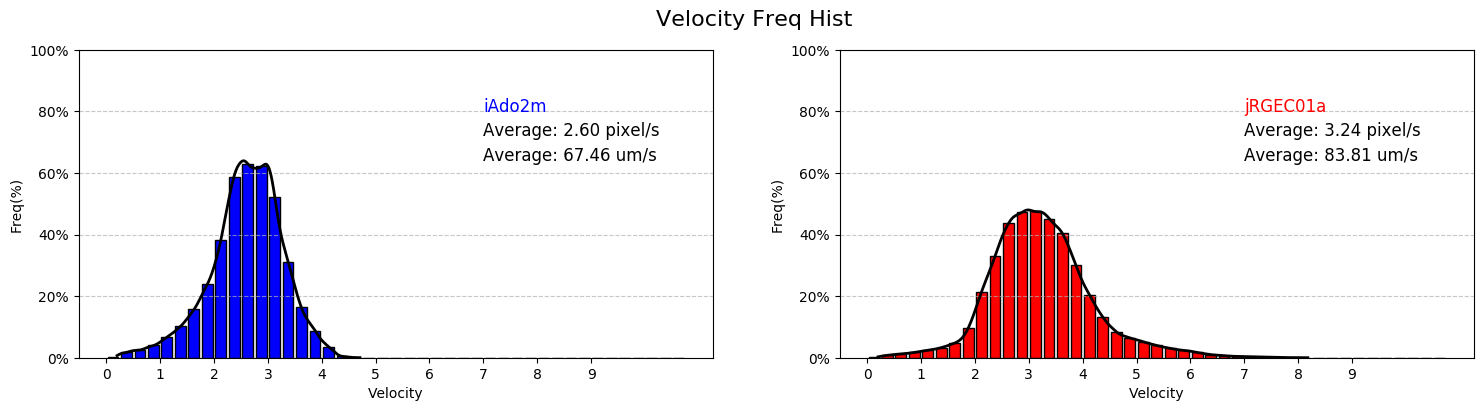

In [102]:
iAdo2m_vel = np.sqrt(iAdo2m_ws_x**2 + iAdo2m_ws_y**2)
jRGEC01a_vel = np.sqrt(jRGEC01a_ws_x**2 + jRGEC01a_ws_y**2)

plt.figure(figsize=(18, 4))
plt.subplot(121)
data1 = iAdo2m_vel[70:100, 50:200, 200:300].flatten()
data1 = data1[data1>0.2]
plt.hist(data1, bins=np.arange(0, 11, 0.25), rwidth=0.8, color='blue', edgecolor='black', density=True)
kde1 = stats.gaussian_kde(data1)
x1 = np.linspace(min(data1), max(data1), 1000)
plt.plot(x1, kde1(x1), color='black', linewidth=2)

plt.xticks(range(10))
plt.xlabel('Velocity')
plt.ylabel('Freq(%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
plt.ylim(0, 1.0)

mean1 = np.mean(data1)
plt.text(7, 0.72, f'Average: {mean1:.2f} pixel/s', fontsize=12, color='black')
plt.text(7, 0.64, f'Average: {(mean1*25.9):.2f} um/s', fontsize=12, color='black')
plt.text(7, 0.8, 'iAdo2m', fontsize=12, color='blue')

plt.subplot(122)
data2 = jRGEC01a_vel[70:100, 50:200, 200:300].flatten()
data2 = data2[data2>0.2]
plt.hist(data2, bins=np.arange(0, 11, 0.25), rwidth=0.8, color='red', edgecolor='black', density=True)
kde2 = stats.gaussian_kde(data2)
x2 = np.linspace(min(data2), max(data2), 1000)
plt.plot(x2, kde2(x2), color='black', linewidth=2)

plt.xticks(range(10))
plt.xlabel('Velocity')
plt.ylabel('Freq(%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
plt.ylim(0, 1.0)

mean2 = np.mean(data2)
plt.text(7, 0.72, f'Average: {mean2:.2f} pixel/s', fontsize=12, color='black')
plt.text(7, 0.64, f'Average: {(mean2*25.9):.2f} um/s', fontsize=12, color='black')
plt.text(7, 0.8, 'jRGEC01a', fontsize=12, color='red')

plt.suptitle('Velocity Freq Hist', fontsize=16)
plt.savefig('../Velocity_freq_hist.png')
plt.show()

In [103]:
# find the peak time and slope of every pixel

def find_time(ori_data, st, et, window_size=None):

    data = ori_data[st:et]
    data[np.isnan(data)] = 0
    
    peak_idx = []
    start_idx = []
    end_idx = []
    increase_period = []
    decrease_period = []
    rising_k = []
    fallen_k = []

    t, h, w = data.shape

    for i in range(h):
        for j in range(w):
            if window_size:
                curr_data = np.convolve(data[:,i,j], np.ones(window_size)/window_size, mode='same')
            else:
                curr_data = data[:,i,j]

            if np.argmax(curr_data) != 0:
                
                peak = np.max(curr_data)
                arg_max = np.argmax(curr_data)

                half1 = sorted(abs(curr_data[:arg_max]-peak/2))[0]
                arg_min1 = np.argwhere(abs(curr_data[:arg_max]-peak/2)==half1)[0][0]

                half2 = sorted(abs(curr_data[arg_max:]-peak/2))[0]
                arg_min2 = arg_max + np.argwhere(abs(curr_data[arg_max:]-peak/2)==half2)[0][0]

                start_idx.append(st+arg_min1)
                peak_idx.append(st+arg_max)
                end_idx.append(st+arg_min2)
                increase_period.append(arg_max-arg_min1)
                decrease_period.append(arg_min2-arg_max)
                
                up_k = ((curr_data[arg_max] - curr_data[arg_min1]) / (arg_max - arg_min1))
                down_k = ((curr_data[arg_max] - curr_data[arg_min2]) / (arg_max - arg_min2))
                rising_k.append(up_k)
                fallen_k.append(down_k)

    return peak_idx, start_idx, end_idx, increase_period, decrease_period, rising_k, fallen_k

In [104]:
iAdo2m_pi, iAdo2m_si, iAdo2m_ei, iAdo2m_ip, iAdo2m_dp, iAdo2m_up_k, iAdo2m_down_k = find_time(iAdo2m, st=1050, et=1450)
jRGECO1a_pi, jRGECO1a_si, jRGECO1a_ei, jRGECO1a_ip, jRGECO1a_dp, jRGECO1a_up_k, jRGECO1a_down_k = find_time(jRGEC01a, st=1050, et=1450)

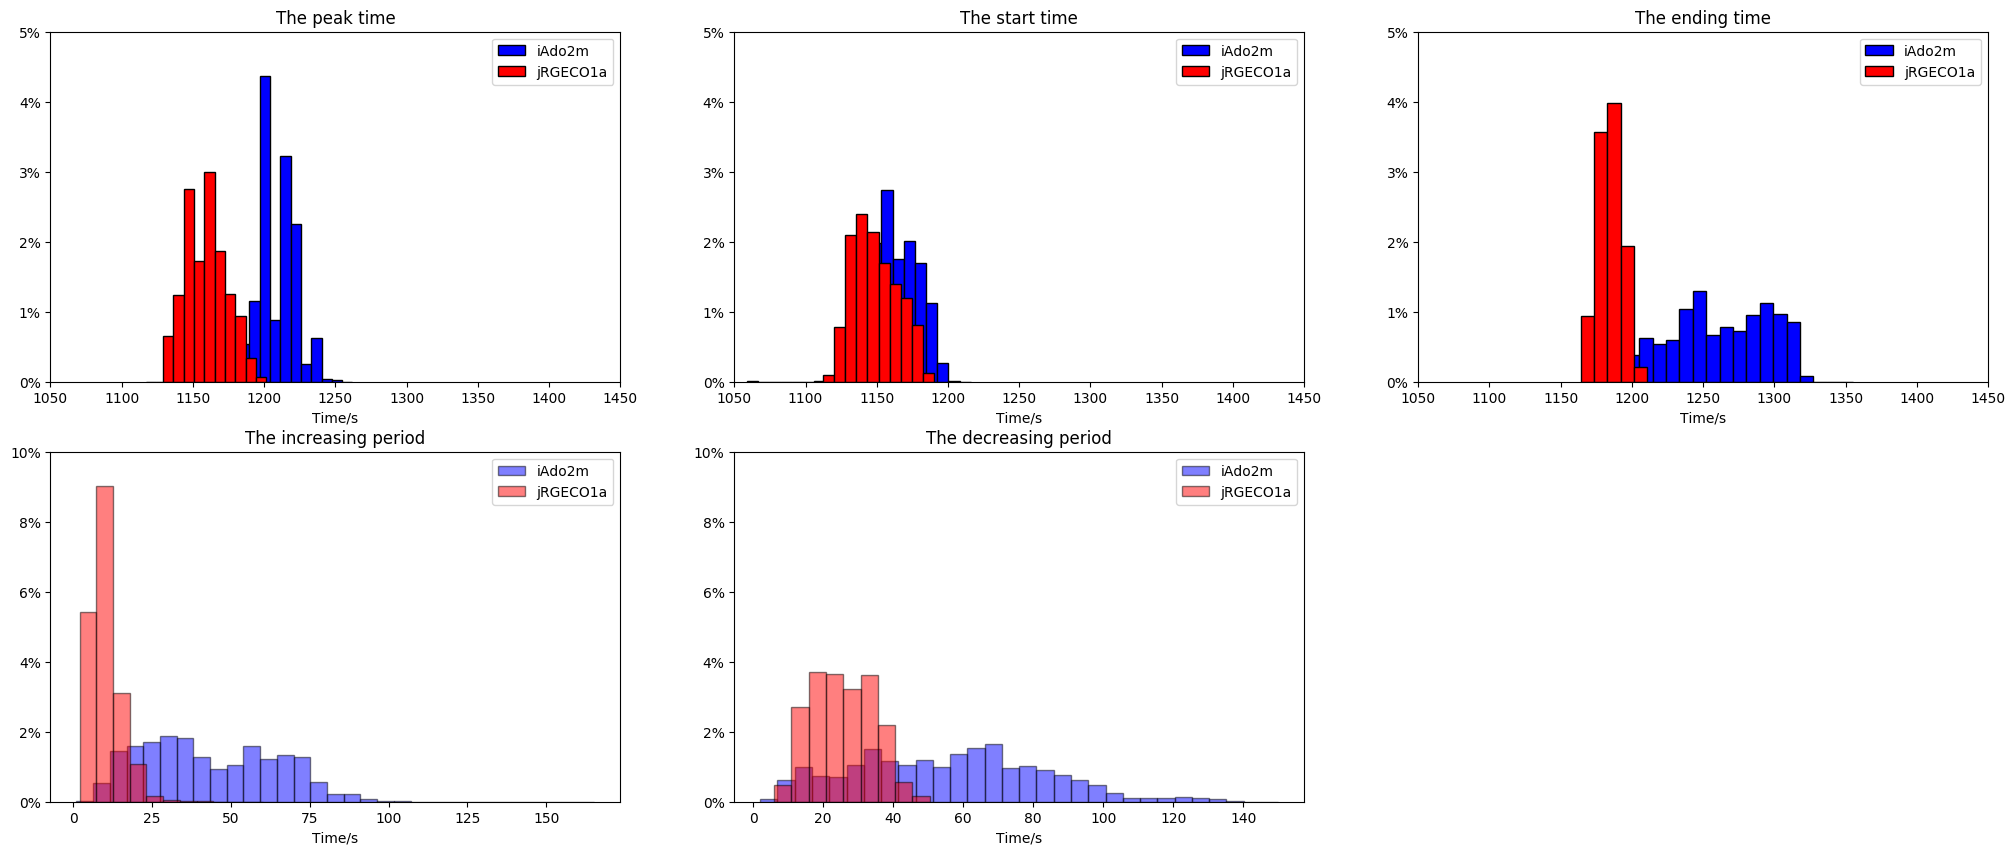

In [107]:
def bin_num(iAdo2m_val, jRGEC01a_val, num=20):
    data_range = max(max(iAdo2m_val), max(jRGEC01a_val)) - min(min(iAdo2m_val), min(jRGEC01a_val))
    bin_width = data_range / num
    iAdo2m_bin = np.arange(min(iAdo2m_val), max(iAdo2m_val) + bin_width, bin_width)
    jRGEC01a_bin = np.arange(min(jRGEC01a_val), max(jRGEC01a_val) + bin_width, bin_width)
    return (iAdo2m_bin, jRGEC01a_bin)

plt.figure(figsize=(25, 10))
plt.subplot(231)
plt.hist(iAdo2m_pi, bins=bin_num(iAdo2m_pi, jRGECO1a_pi)[0], color='blue', edgecolor='black', density=True)
plt.hist(jRGECO1a_pi, bins=bin_num(iAdo2m_pi, jRGECO1a_pi)[1], color='red', edgecolor='black', density=True)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
plt.xlim(1050, 1450)
plt.ylim(0, 0.05)
plt.xlabel('Time/s')
plt.title('The peak time')
plt.legend(['iAdo2m', 'jRGECO1a'])
plt.subplot(232)
plt.hist(iAdo2m_si, bins=bin_num(iAdo2m_si, jRGECO1a_si)[0], color='blue', edgecolor='black', density=True)
plt.hist(jRGECO1a_si, bins=bin_num(iAdo2m_si, jRGECO1a_si)[1], color='red', edgecolor='black', density=True)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
plt.xlim(1050,1450)
plt.xlabel('Time/s')
plt.ylim(0,0.05)
plt.title('The start time')
plt.legend(['iAdo2m', 'jRGECO1a'])
plt.subplot(233)
plt.hist(iAdo2m_ei, bins=bin_num(iAdo2m_ei, jRGECO1a_ei)[0], color='blue', edgecolor='black', density=True)
plt.hist(jRGECO1a_ei, bins=bin_num(iAdo2m_ei, jRGECO1a_ei)[1], color='red', edgecolor='black', density=True)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
plt.xlim(1050,1450)
plt.xlabel('Time/s')
plt.ylim(0,0.05)
plt.title('The ending time')
plt.legend(['iAdo2m', 'jRGECO1a'])
plt.subplot(234)
plt.hist(iAdo2m_ip, bins=bin_num(iAdo2m_ip, jRGECO1a_ip, num=30)[0], color='blue', edgecolor='black', density=True, alpha=0.5)
plt.hist(jRGECO1a_ip, bins=bin_num(iAdo2m_ip, jRGECO1a_ip, num=30)[1], color='red', edgecolor='black', density=True, alpha=0.5)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
plt.xlabel('Time/s')
plt.ylim(0,0.1)
plt.title('The increasing period')
plt.legend(['iAdo2m', 'jRGECO1a'])
plt.subplot(235)
plt.hist(iAdo2m_dp, bins=bin_num(iAdo2m_dp, jRGECO1a_dp, num=30)[0], color='blue', edgecolor='black', density=True, alpha=0.5)
plt.hist(jRGECO1a_dp, bins=bin_num(iAdo2m_dp, jRGECO1a_dp, num=30)[1], color='red', edgecolor='black', density=True, alpha=0.5)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
plt.xlabel('Time/s')
plt.ylim(0,0.1)
plt.title('The decreasing period')
plt.legend(['iAdo2m', 'jRGECO1a'])
plt.show()

## There is a distinction of wave time between iAdo2m and jRGEC01a

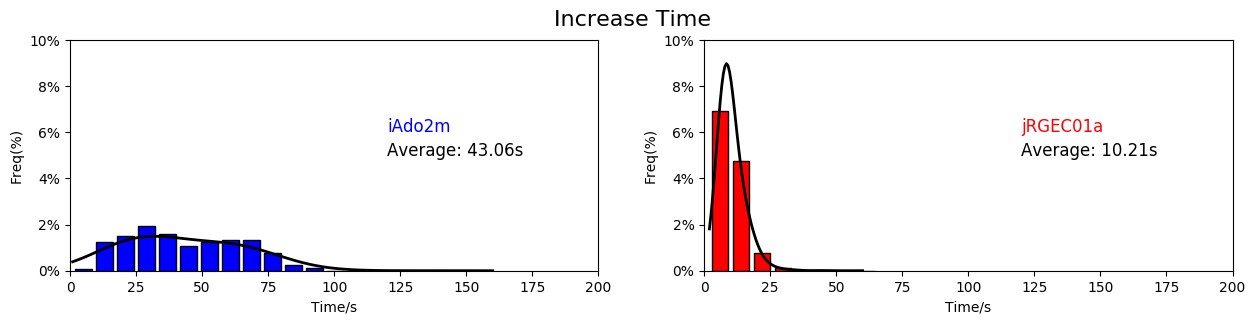

In [108]:
plt.figure(figsize=(15,3))
plt.subplot(121)
plt.hist(iAdo2m_ip, bins=bin_num(iAdo2m_ip, jRGECO1a_ip)[0], rwidth=0.8, color='blue', edgecolor='black', density=True)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
kde1 = stats.gaussian_kde(iAdo2m_ip, bw_method=0.6)
x1 = np.linspace(min(iAdo2m_ip), max(iAdo2m_ip), 100)
plt.plot(x1, kde1(x1), color='black', linewidth=2)
mean1 = np.mean(iAdo2m_ip)
plt.text(120, 0.05, f'Average: {mean1:.2f}s', fontsize=12, color='black')
plt.text(120, 0.06, 'iAdo2m', fontsize=12, color='blue')
plt.xlim(0,200)
plt.ylim(0,0.1)
plt.xlabel('Time/s')
plt.ylabel('Freq(%)')

plt.subplot(122)
plt.hist(jRGECO1a_ip, bins=bin_num(iAdo2m_ip, jRGECO1a_ip)[1], rwidth=0.8, color='red', edgecolor='black', density=True)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
kde2 = stats.gaussian_kde(jRGECO1a_ip, bw_method=0.6)
x2 = np.linspace(min(jRGECO1a_ip), max(jRGECO1a_ip), 100)
plt.plot(x2, kde2(x2), color='black', linewidth=2)
mean2 = np.mean(jRGECO1a_ip)
plt.text(120, 0.05, f'Average: {mean2:.2f}s', fontsize=12, color='black')
plt.text(120, 0.06, 'jRGEC01a', fontsize=12, color='red')
plt.xlim(0,200)
plt.ylim(0,0.1)
plt.xlabel('Time/s')
plt.ylabel('Freq(%)')

plt.suptitle('Increase Time', fontsize=16)
plt.savefig('../Increase_time.png')
plt.show()

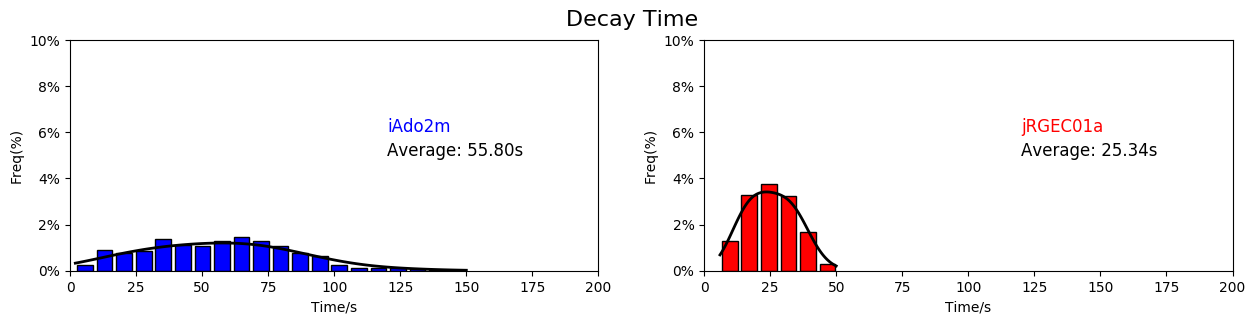

In [109]:
plt.figure(figsize=(15,3))
plt.subplot(121)
plt.hist(iAdo2m_dp, bins=bin_num(iAdo2m_dp, jRGECO1a_dp)[0], rwidth=0.8, color='blue', edgecolor='black', density=True)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
kde3 = stats.gaussian_kde(iAdo2m_dp, bw_method=0.6)
x3 = np.linspace(min(iAdo2m_dp), max(iAdo2m_dp), 100)
plt.plot(x3, kde3(x3), color='black', linewidth=2)
mean3 = np.mean(iAdo2m_dp)
plt.text(120, 0.05, f'Average: {mean3:.2f}s', fontsize=12, color='black')
plt.text(120, 0.06, 'iAdo2m', fontsize=12, color='blue')
plt.xlim(0,200)
plt.ylim(0,0.1)
plt.xlabel('Time/s')
plt.ylabel('Freq(%)')

plt.subplot(122)
plt.hist(jRGECO1a_dp, bins=bin_num(iAdo2m_dp, jRGECO1a_dp)[1], rwidth=0.8, color='red', edgecolor='black', density=True)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
kde4 = stats.gaussian_kde(jRGECO1a_dp, bw_method=0.6)
x4 = np.linspace(min(jRGECO1a_dp), max(jRGECO1a_dp), 100)
plt.plot(x4, kde4(x4), color='black', linewidth=2)
mean4 = np.mean(jRGECO1a_dp)
plt.text(120, 0.05, f'Average: {mean4:.2f}s', fontsize=12, color='black')
plt.text(120, 0.06, 'jRGEC01a', fontsize=12, color='red')
plt.xlim(0,200)
plt.ylim(0,0.1)
plt.xlabel('Time/s')
plt.ylabel('Freq(%)')

plt.suptitle('Decay Time', fontsize=16)
plt.savefig('../Decay_time.png')
plt.show()

In [110]:
# find the points

def find_special_points(ori_data, st, et, window_size=None):

    data = ori_data[st:et]
    data[np.isnan(data)] = 0

    peak_img = np.zeros_like(data[0])
    t50_start = np.zeros_like(data[0])
    t50_end = np.zeros_like(data[0])
    rising_img = np.zeros_like(data[0])
    decay_img = np.zeros_like(data[0])

    t, h, w = data.shape

    for i in range(h):
        for j in range(w):
            if window_size:
                curr_data = np.convolve(data[:,i,j], np.ones(window_size)/window_size, mode='same')
            else:
                curr_data = data[:,i,j]

            if np.argmax(curr_data) != 0:
                
                peak = np.max(curr_data)
                arg_max = np.argmax(curr_data)

                half1 = sorted(abs(curr_data[:arg_max]-peak/2))[0]
                arg_min1 = np.argwhere(abs(curr_data[:arg_max]-peak/2)==half1)[0][0]

                half2 = sorted(abs(curr_data[arg_max:]-peak/2))[0]
                arg_min2 = arg_max + np.argwhere(abs(curr_data[arg_max:]-peak/2)==half2)[0][0]

                peak_img[i,j] = st+arg_max
                t50_start[i,j] = st+arg_min1
                t50_end[i,j] = st+arg_min2

                rising_img[i,j] = arg_max - arg_min1
                decay_img[i,j] = arg_min2 - arg_max
    
    peak_img[np.isnan(ori_data[0])] = np.nan
    t50_start[np.isnan(ori_data[0])] = np.nan
    t50_end[np.isnan(ori_data[0])] = np.nan
    rising_img[np.isnan(ori_data[0])] = np.nan
    decay_img[np.isnan(ori_data[0])] = np.nan

    return (peak_img, t50_start, t50_end, rising_img, decay_img)

In [111]:
iAdo2m_idx_img = find_special_points(iAdo2m, st=1050, et=1450, window_size=10)
jRGEC01a_idx_img = find_special_points(jRGEC01a, st=1050, et=1450, window_size=10)

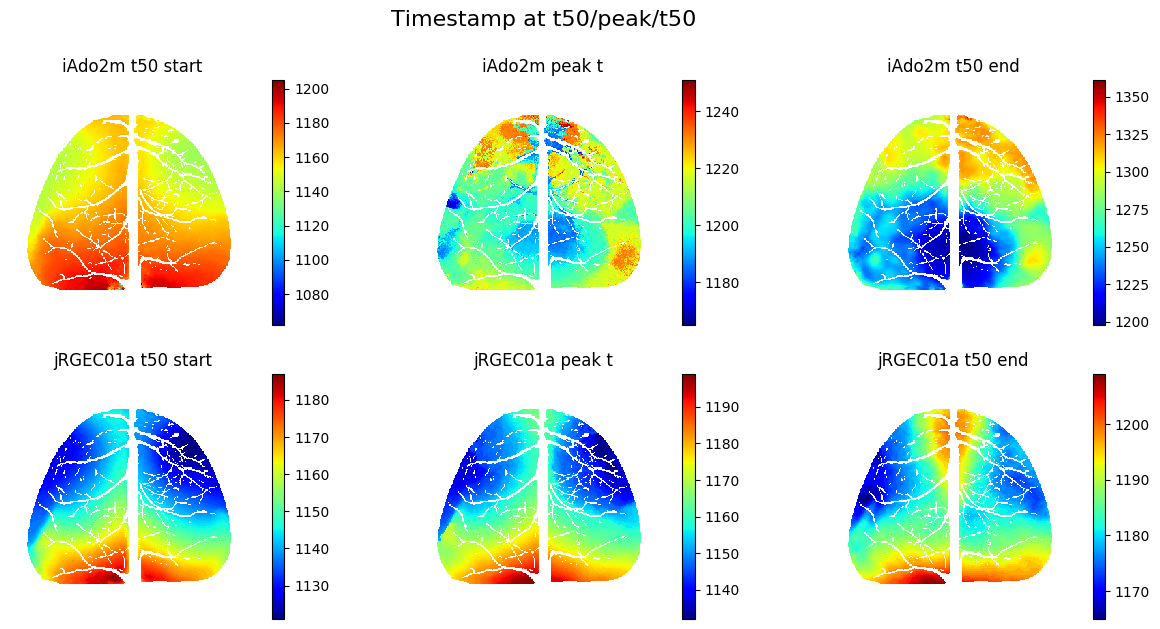

In [115]:
from matplotlib.ticker import MultipleLocator

fig, axs = plt.subplots(2, 3, figsize=(15, 7))

images = [iAdo2m_idx_img[1], iAdo2m_idx_img[0], iAdo2m_idx_img[2], jRGEC01a_idx_img[1], jRGEC01a_idx_img[0], jRGEC01a_idx_img[2]]
titles = ['iAdo2m t50 start', 'iAdo2m peak t', 'iAdo2m t50 end', 'jRGEC01a t50 start', 'jRGEC01a peak t', 'jRGEC01a t50 end']

for ax, img, title in zip(axs.flat, images, titles):
    im = ax.imshow(img, cmap='jet')
    ax.set_title(title)
    ax.axis('off')
    cbar = plt.colorbar(im, ax=ax)

# cbar = fig.colorbar(im, ax=axs.ravel().tolist(), orientation='horizontal', pad=0, shrink=0.6)
# cbar.set_label('timestamp', rotation=0, labelpad=10)
# cbar.ax.xaxis.set_major_locator(MultipleLocator(40))

plt.suptitle('Timestamp at t50/peak/t50', fontsize=16)
plt.show()

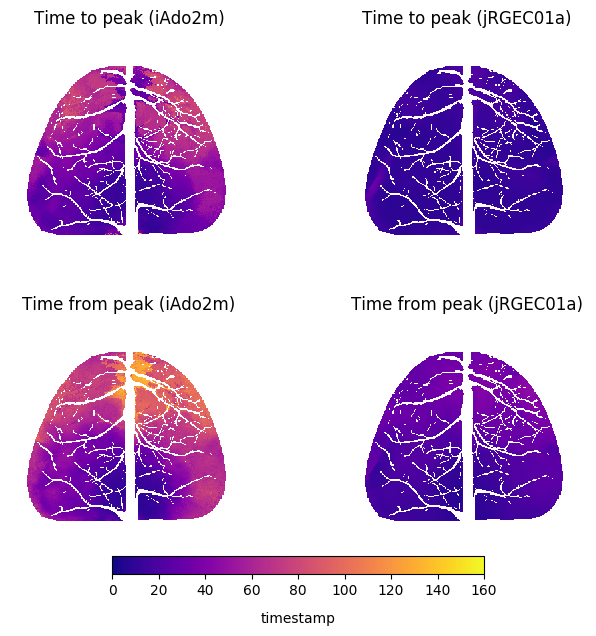

In [116]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 8))

# Plot images on subplots
images = [iAdo2m_idx_img[3], jRGEC01a_idx_img[3], iAdo2m_idx_img[4], jRGEC01a_idx_img[4]]
titles = ['Time to peak (iAdo2m)', 'Time to peak (jRGEC01a)', 'Time from peak (iAdo2m)', 'Time from peak (jRGEC01a)']

for ax, img, title in zip((ax1, ax2, ax3, ax4), images, titles):
    im = ax.imshow(img, cmap='plasma', vmin=0, vmax=160)
    ax.set_title(title)
    ax.axis('off')

# Create a shared colorbar
cbar = fig.colorbar(im, ax=(ax1, ax2, ax3, ax4), orientation='horizontal', pad=0, shrink=0.6)
cbar.set_label('timestamp', rotation=0, labelpad=10)
cbar.ax.xaxis.set_major_locator(MultipleLocator(20))

plt.show()

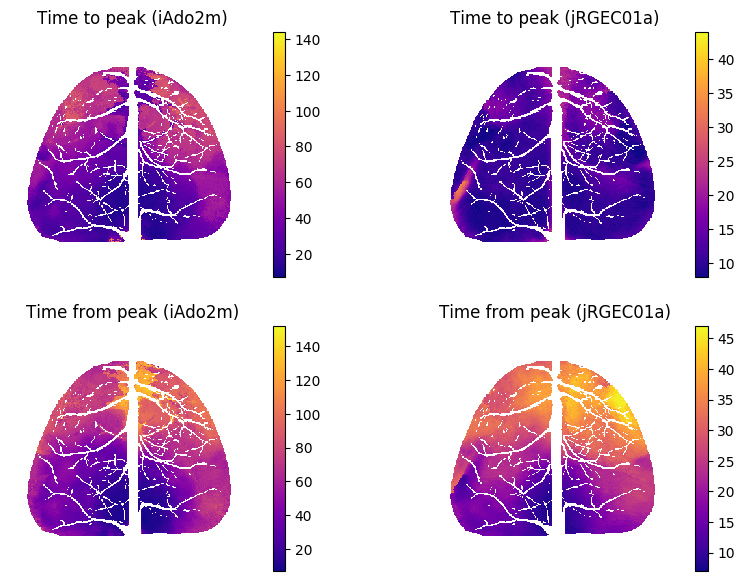

In [119]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 7))

# Plot images on subplots
images = [iAdo2m_idx_img[3], jRGEC01a_idx_img[3], iAdo2m_idx_img[4], jRGEC01a_idx_img[4]]
titles = ['Time to peak (iAdo2m)', 'Time to peak (jRGEC01a)', 'Time from peak (iAdo2m)', 'Time from peak (jRGEC01a)']

for ax, img, title in zip((ax1, ax2, ax3, ax4), images, titles):
    im = ax.imshow(img, cmap='plasma')
    ax.set_title(title)
    ax.axis('off')
    cbar = plt.colorbar(im, ax=ax)

# Create a shared colorbar
# cbar = fig.colorbar(im, ax=(ax1, ax2, ax3, ax4), orientation='horizontal', pad=0, shrink=0.6)
# cbar.set_label('timestamp', rotation=0, labelpad=10)
# cbar.ax.xaxis.set_major_locator(MultipleLocator(20))

plt.show()